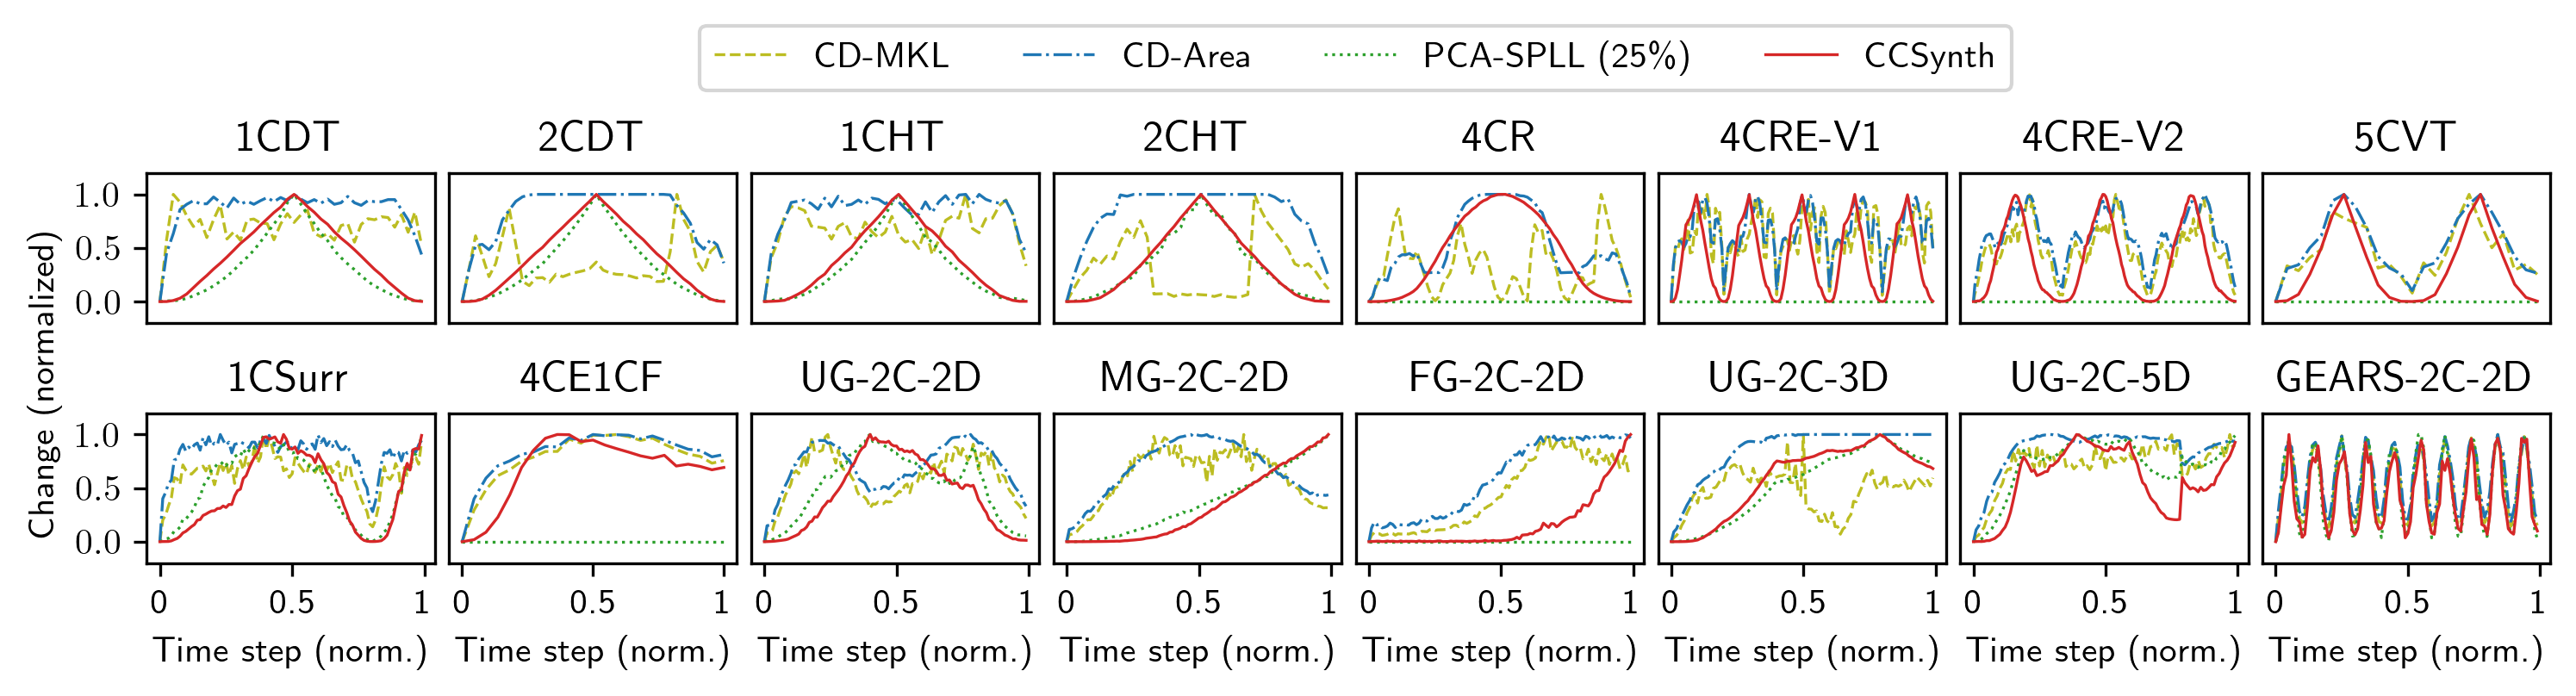

In [1]:
import prose.datainsights as di
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from sklearn.decomposition import PCA
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os
import sys
from IPython.display import HTML
import warnings
from matplotlib import rc
from matplotlib import rcParams

systemName = 'CCSynth'
rcParams['font.family'] = 'sans-serif'
rc('text', usetex=True)

warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join("Baseline", "PCA-SPLL"))
if module_path not in sys.path:    
    sys.path.append(module_path)
from SPLL import SPLL
path = os.getcwd()
path = path[0].lower() + path[2:]
current_directory = os.getcwd()

CD_executable = os.path.join(current_directory, "Baseline", "PCA-CD", "ChangeDetection", "CD")
data_source = os.path.join(current_directory, "data", "uncompressed", "EVL/")
output_prefix = os.path.join(current_directory, "data", "uncompressed", "EVL", "results/")
window_sizes = {
    "1CDT":400,
    "2CDT":400,
    "1CHT":400,
    "2CHT":400,
    "4CR":2000,
    "4CRE-V1":1000,
    "4CRE-V2":1000,
    "5CVT":1000,
    "1CSurr":600,
    "4CE1CF":7500,
    "UG-2C-2D":1000,
    "MG-2C-2D":2000,
    "FG-2C-2D":2000,
    "UG-2C-3D":2000,
    "UG-2C-5D":2000,
    "GEARS-2C-2D":2000,
}
        
def get_df(dataset, raw=True):
    df = pd.read_csv(data_source + dataset + ".txt", header=None)
    
    if not raw:
        for col in df.columns:
            if len(list(df[col].unique())) < 10:
                df[col] = df[col].apply(str)
    return df

def get_cd_violations(dataset, window, div_metric):
    input_source = data_source  + "_" + dataset + ".txt"
    try:
        open(data_source + "_" + dataset + ".txt", "r")
    except:        
        infile = open(data_source + dataset + ".txt", "r")
        outfile = open(data_source + "_" + dataset + ".txt", "w")
        for line in infile:
            line = line.replace(",", "\t")
            outfile.write(line)
        outfile.close()
        
    nDim = get_df(dataset).shape[1]
    
    seg_fault_hack = "0"
    if dataset == "1CSurr":
        seg_fault_hack = "1"
    
    command = 'bash -c'
    command = command.split(sep=" ")
    cd_command = " ".join([CD_executable,
                           input_source,
                           str(window),
                           "500",
                           output_prefix + "output.txt",
                           str(nDim),
                           "0.005",
                           str(div_metric),
                           seg_fault_hack])
    command.append(cd_command)
    p = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate()

    output_source = data_source + "results/output.txt"    
    violations = [float(violation) for violation in open(output_source)]    
    os.remove(output_source)
    return violations


def get_violations(approaches, dataset, window):    
    all_violations = dict()
    
    df_raw = get_df(dataset, raw=True)
    df = get_df(dataset, raw=False)
    
    for approach in approaches:
        violations = []
        if approach.startswith("CD-Area"):
            violations = get_cd_violations(dataset, window, 1)    
        
        elif approach.startswith("CD-MKL"):
            violations = get_cd_violations(dataset, window, 2)  
            
        elif approach.startswith("PCA-SPLL"):
            train_df = df_raw[:window]
            
            pca = PCA()
            pca.fit(train_df)
            
            # Keep the least variant features
            feature_indices = np.where(pca.explained_variance_ratio_ < 0.35)[0]
            train_PCA = pca.transform(train_df)[:, feature_indices.tolist()]
            
            n_chunks = int(df_raw.shape[0]/window)
            violations = []
            for i in range(n_chunks):  
                test_df = df_raw[i * window: (i + 1) * window]
                if np.size(feature_indices) < 2:
                    # Guard against empty clusters...
                    st_raw, st_pca = 0, 0
                else:
                    # Transform with W1's coefficients, only keep the least variant features            
                    test_PCA = pca.transform(test_df)[:, feature_indices.tolist()]
                    _, _, st_pca = SPLL(train_PCA, test_PCA)
                
                violations.append(st_pca)
       
        else:
            max_self_violation_threshold = 0.15
            if approach == "PCA":
                assertions = di.learn_assertions(df[:window], max_self_violation = max_self_violation_threshold) 
            if approach == "DT":
                assertions = di.learn_assertions(df[:window], learn_decision_tree=True, max_self_violation = max_self_violation_threshold)      
            n_chunks = int(df.shape[0]/window)
            violations = []
            for i in range(n_chunks):            
                test_df = df[i * window: (i + 1) * window]
                result = assertions.evaluate(test_df, normalizeViolation=False)
                violations.append(result.avg_violation)     
        
        all_violations[approach] =  np.array(violations)
    
    return all_violations

rcParams['figure.dpi'] = 300
approaches = ["CD-MKL",  "CD-Area", "PCA-SPLL", "DT"]
approach_names = ["CD-MKL", "CD-Area", "PCA-SPLL (25\%)", systemName]
colors = ["C8", "C0", "C2", "C3"]
lss = ['--','-.', ':', '-',]
nCol = 8

fig, ax = plt.subplots(2, nCol)
fig.set_size_inches(12, 2)

cur_plot_idx = 0

for dataset, window in window_sizes.items():          
    if cur_plot_idx == 8 or cur_plot_idx == 0 or True:
        all_violations = get_violations(approaches, dataset, window)     
        for approach in approaches:        
            cur_plot = ax[cur_plot_idx//nCol][cur_plot_idx%nCol]

            violations = all_violations[approach]
            
            if max(violations) > 0:
                violations = (violations - np.min(violations))/(np.max(violations) - np.min(violations))

            color = colors[approaches.index(approach)]
            ls = lss[approaches.index(approach)]
            approach_name = approach_names[approaches.index(approach)]        

            cur_plot.plot(violations, color=color, linestyle=ls, label=approach_name, linewidth=0.8)  

        cur_plot.set_title(dataset)
        cur_plot.set_ylim(-0.2, 1.2)

        if cur_plot_idx % nCol == 0:
            cur_plot.set_yticks(np.arange(0, 1.1, 0.5))        
        else:
            cur_plot.set_yticks([])
            
        if cur_plot_idx == nCol:
            cur_plot.set_ylabel("Change (normalized)", position=(1, 1.2))


        if cur_plot_idx >= nCol:
            cur_plot.set_xticks(np.arange(0, len(violations) + 1, len(violations)//2))            
            
            labels = cur_plot.get_xticks().tolist()
            
            labels[0] = "0"
            labels[1] = "0.5"
            labels[2] = "1"
            
            cur_plot.set_xticklabels(labels)
            cur_plot.set_xlabel("Time step (norm.)")
        else:
            cur_plot.set_xticks([])        

        if cur_plot_idx == 0:
            cur_plot.legend(ncol=4,loc="upper center", bbox_to_anchor=[4.2,2.1],)
    
    cur_plot_idx += 1

fig.subplots_adjust(hspace=0.6, wspace=0.05)
plt.savefig(os.path.join(current_directory, "Plots", "Figure_8.pdf"), bbox_inches="tight")
plt.show()